# Avaliação de Monte Carlo
#### Prof. Armando Alves Neto - Introdução ao Aprendizado por Reforço - PPGEE/UFMG

Dada uma política $\pi(s)$, podemos avaliar sua função valor via um algoritmo de Monte Carlos. A duas opções: (i) *first-visit* e (ii) *every-visit*.

Importando bibliotecas.

In [1]:
import sys
sys.path.insert(0, "../aula03/")
import numpy as np
import class_gridworld_env as cge

Definindo parâmetros principais do algoritmo.

In [2]:
GAMMA = 0.99

Criando uma classe para gerenciar as listas de *retornos(s)* para todos os estados.

In [3]:
class Returns:
    ##########################################
    def __init__(self):
        self.r = []
    ##########################################
    def append(self, G):
        self.r.append(G) 
    ##########################################
    # média corrente dos retornos(s)
    def getAverage(self):
        if not self.r:
            return 0.0
        else:
            return np.mean(self.r)

Agora criando a classe ```MCPrediction```. Aqui utilizamos uma política $\pi(s)$ gerada pela iteração de valor da aula anterior.

In [4]:
class MCPrediction:
    ##########################################
    def __init__(self, parameters):

        # environment
        self.env = cge.Gridworld_Env(size=8)
        self.size = self.env.getSize()

        # fator de desconto
        self.gamma = GAMMA

        # inicia o mundo
        self.reset()
        
        # eh first-visit?
        self.first_visit = parameters['first-visit']

    ##########################################
    def reset(self):

        # reseta ambiente
        self.env.reset()

        # value function 
        self.value = np.zeros((self.size, self.size))
        
        # carrega politica gerada pela iteracao de valor da aula anterior
        policy = np.load('../aula03/policy.npz', allow_pickle=True)
        self.pi = policy['policy']
        
        # retornos(s)
        self.returns = [ [ Returns() for i in range(self.size) ] for j in range(self.size) ]

Usando $\pi(s)$ para gerar um episódio: $S_0$, $A_0$, $R_1$, $\ldots$, $S_{T-1}$, $A_{T-1}$, $R_T$.

In [5]:
class MCPrediction(MCPrediction):
    ##########################################
    # simula um episodio até o fim seguindo a politica corrente
    def oneEpisode(self, max_iter=1000):

        # inicia o ambiente (começa aleatoriamente)
        S = self.env.reset()

        # listas da trajetoria S_{T-1}, A_{T-1}, R_{T}, ....
        rewards, states = ([] for i in range(2))

        for _ in range(max_iter):
            
            # politica inicial
            A = self.env.actions[self.pi[S]]

            # passo de interacao com o ambiente
            [Sl, R, done, _] = self.env.step(S, A)

            # Salva S_{T-1}, R_{T}, ....
            states.append(S)
            rewards.append(R)

            # chegou a um estado terminal?
            if done: break
            
            # proximo estado
            S = Sl

        return [states, rewards]

Computa a função valor $v(S_t) \gets \textrm{média}(Retornos(S_t))$

In [6]:
class MCPrediction(MCPrediction):
    ##########################################
    def runEpsisode(self):

        # gera um episodio seguindo a politica corrente
        [states, rewards] = self.oneEpisode()

        G = 0.0
        
        # processa experiencia (de tras para frente)
        for t in reversed(range(len(states))):
            
            # Get S_{T}, R_{T+1}
            s = states[t]
            r = rewards[t]
            
            # first-visit?
            if self.first_visit:
                if s in states[0:t]:
                    continue

            # atualiza V(s)
            G = self.gamma*G + r
            self.returns[s[0]][s[1]].append(G)
            self.value[s] = self.returns[s[0]][s[1]].getAverage()

        return self.value

Programa principal:
- episodes: número de episódios
- first-visit: True or False (False equivale a *every-visit*)

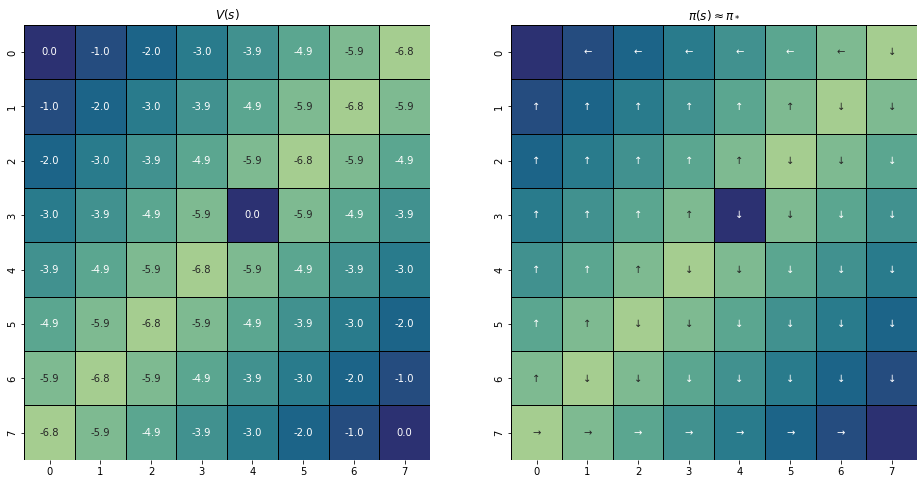

In [7]:
if __name__ == "__main__":
    
    # parametros
    parameters = {'episodes'    : 180,
                  'first-visit' : True}

    # cria a classe
    mc_pred = MCPrediction(parameters)
    
    # tabela de valores obtida
    for _ in range(parameters['episodes']):
        value_table = mc_pred.runEpsisode()

    # renderiza
    mc_pred.env.render(value=value_table, pi=mc_pred.pi)